# 2D Image compression
---

I borrowed a lot of the code for this example from a 2014 set of notes by Bugra Akyildiz:

http://bugra.github.io/work/notes/2014-07-12/discre-fourier-cosine-transform-dft-dct-image-compression/

In this section, we'll continue the ideas we explored in the 1-D compression section on an *actual* 2-D image. The principles are very similar; we just have to apply the Discrete Cosine Transform in *two* directions (the two dimensions of the image pixel data) rather than 1.

If you're new to `.ipynb` notebooks, make sure you run *all* cells here so you have all the tools necessary from the `import` statements below.

In [60]:
# Magic and imports

%matplotlib inline
import io
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy import fftpack
import IPython

In [134]:
# Setup of helper functions for compression to follow

def get_image_from_file(image_filename='kitty.jpg', size=(128, 128)):
    image = Image.open(image_filename)
    img_color = image.resize(size, 1)
    img_grey = img_color.convert('L')
    img = np.array(img_grey, dtype=np.float)
    return np.fliplr(img.T)
 
def get_2D_dct(img):
    """ Get 2D Cosine Transform of Image
    """
    return fftpack.dct(fftpack.dct(img.T, norm='ortho').T, norm='ortho')

def get_2d_idct(coefficients):
    """ Get 2D Inverse Cosine Transform of Image
    """
    return fftpack.idct(fftpack.idct(coefficients.T, norm='ortho').T, norm='ortho')

def get_reconstructed_image(raw):
    img = raw.clip(0, 255)
    img = img.astype('uint8')
    img = Image.fromarray(img)
    return img

def get_rescaled_reconstructed_image(raw):
    maxmag = 0
    rowind = 0
    
    # brute forcing rescale
    for row in raw:
        colind = 0
        for col in row:
            tempmag = abs(raw[rowind][colind])
            if tempmag > maxmag:
                maxmag = tempmag
            colind += 1
        rowind += 1
        
    scaleFactor = 255/maxmag    
    
    rowind = 0
    for row in raw:
        colind = 0
        for col in row:
            raw[rowind][colind] *= scaleFactor
            colind += 1
        rowind += 1
    
    img = raw.clip(0, 255)
    img = img.astype('uint8')
    img = Image.fromarray(img)
    return img

In [62]:
# loading up a 512 x 384 version of our kitty image; performing many DCT-culling-iDCT compression loops with
# different compression levels

pixels = get_image_from_file(image_filename='kitty.jpg', size=(512, 384))
dct_size = pixels.shape[0]
dct = get_2D_dct(pixels)
reconstructed_images = []

for ii in range(dct_size):
    dct_copy = dct.copy()
    dct_copy[ii:,:] = 0
    dct_copy[:,ii:] = 0
    
    # Reconstructed image
    r_img = get_2d_idct(dct_copy);
    reconstructed_image = get_reconstructed_image(r_img);

    # Create a list of images
    reconstructed_images.append(reconstructed_image);

## Plotting some examples of kitty image compression (512 x 384 image)
---
In the next set of subplots, we'll show examples of different compression levels of the kitty image, much like we did with the 1-D compression exercise. And as in the 1-D example, we're getting these compression factors by only retaining the lower-frequency modes (in 2-D we have a Cartesian product of horizontal and vertical modes) and throwing out the higher-frequency data.

[*Note: these subplots show compression of an ALREADY REDUCED 512 x 384 kitty image. We'll show compression of a more substantial image (higher resolution) below.*]

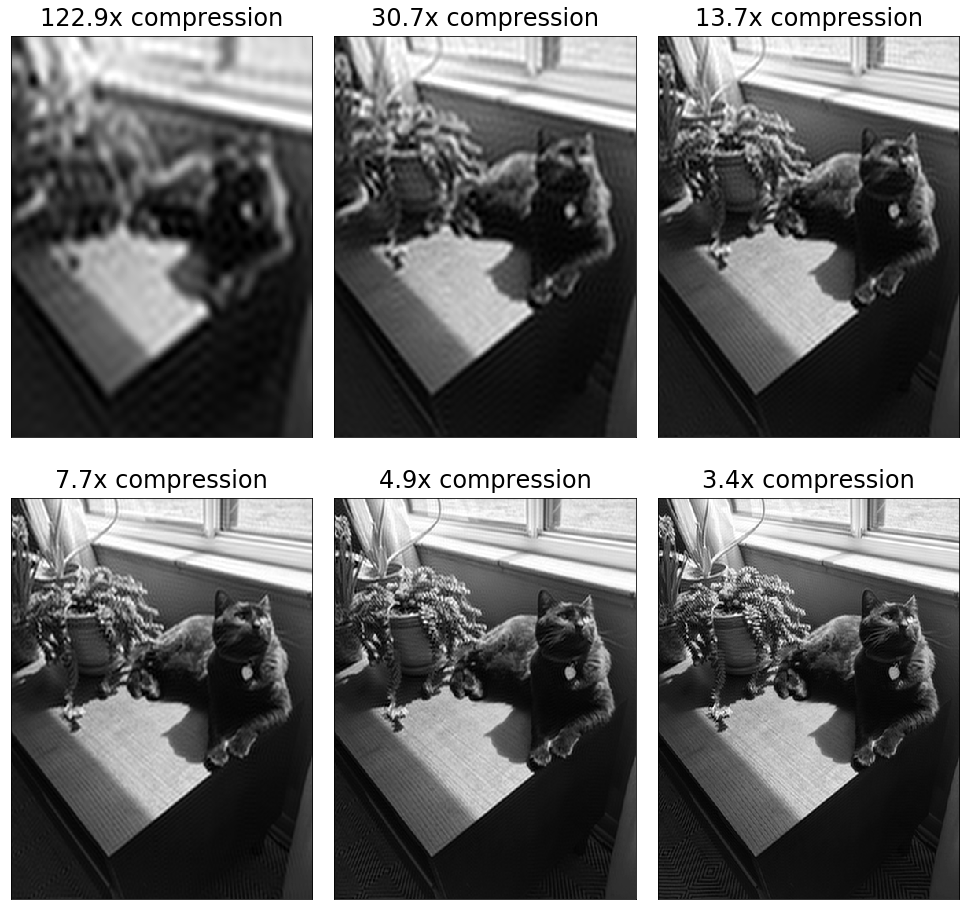

In [94]:
fig = plt.figure(figsize=(17, 17))

# gs1 = gridspec.GridSpec(4, 4)
# gs1.update(wspace=0.02, hspace=0.02) # set the spacing between axes. 

fig.subplots_adjust(hspace=0, wspace=0.075)
plt.rcParams['font.size'] = 20
plt.rcParams['axes.titlepad'] = 10

for ii in range(6):
    plt.subplot(2, 3, ii + 1)
    plt.imshow(reconstructed_images[(ii+1)*40], cmap=plt.cm.gray)
    plt.title('{0:.1f}x compression'.format((512*384)/((ii+1)*40)**2))
    plt.grid(False);
    plt.xticks([]);
    plt.yticks([]);

## Kitty compression from high-resolution image
---
We can get some more impressive results if we start from a high-resolution image and do our DCT from there. The next (single) image starts with the full-size, 4032-by-3024 photo I took of my cat. We then reduce down to a 'mode box' of 630-by-630 (a ~30x compression!) and still retain pretty high qualitative fidelity. Neat!

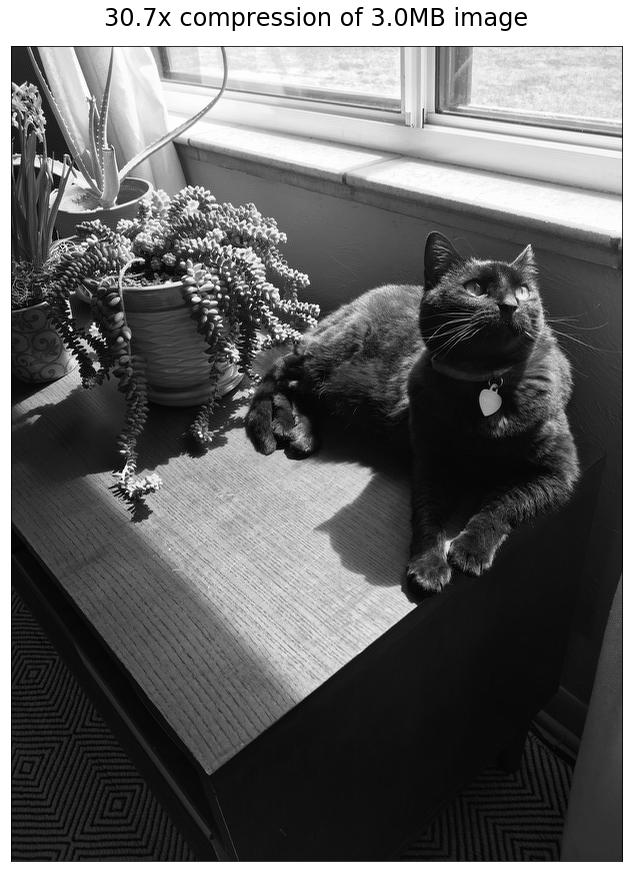

In [93]:
pixels = get_image_from_file(image_filename='kitty.jpg', size=(4032, 3024))
dct_size = pixels.shape[0]
dct = get_2D_dct(pixels)
plt.rcParams['font.size'] = 20
plt.rcParams['axes.titlepad'] = 20

lastRowCol = 630

dct_copy = dct.copy()
dct_copy[lastRowCol:,:] = 0
dct_copy[:,lastRowCol:] = 0

# Reconstructed image
r_img = get_2d_idct(dct_copy);
reconstructed_image = get_reconstructed_image(r_img);

plt.figure(figsize=(15,15))
plt.imshow(reconstructed_image, cmap=plt.cm.gray)
plt.title('{0:.1f}x compression of 3.0MB image'.format((3024*4032)/(lastRowCol**2)))
plt.grid(False);
plt.xticks([]);
plt.yticks([]);

## Visualizing the modes in use during 2D compression
---
With 2D compression we can *also* visualize what functions we're using (as a reduced basis) in construction of the compressed image. We'll do so with a colormap, though, rather than vertical plot.

Immediately below is a color plot (with colormap `magma` - how sweet is *that*?!) of modal magnitudes resulting from our high-resolution DCT.

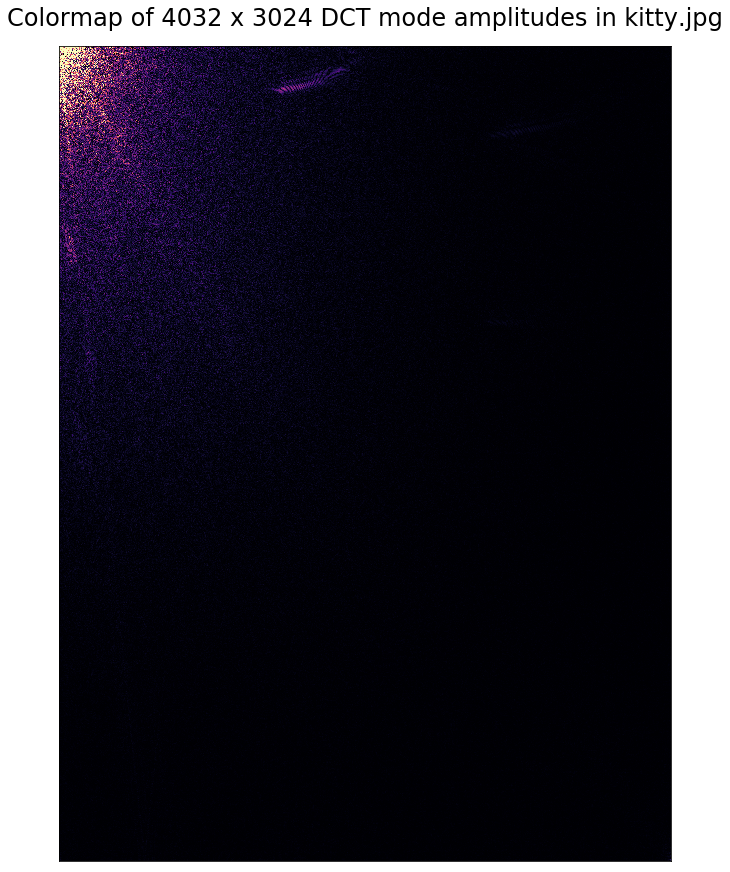

In [98]:
# Plot of frequency intensities (high-res image)

pixels = get_image_from_file(image_filename='kitty.jpg', size=(4032, 3024))
dct_size = pixels.shape[0]
dct = get_2D_dct(pixels)
plt.rcParams['font.size'] = 20
plt.rcParams['axes.titlepad'] = 20

# don't want to blank out any modes just yet
lastRowCol = 5000

dct_copy = dct.copy()
dct_copy[lastRowCol:,:] = 0
dct_copy[:,lastRowCol:] = 0

dct_copy_norm = abs(dct_copy)/np.amax(abs(dct_copy))

# Reconstructed image of dct coeffs
reconstructed_image = get_reconstructed_image(abs(dct_copy));

plt.figure(figsize=(15,15))
plt.title('Colormap of 4032 x 3024 DCT mode amplitudes in kitty.jpg')
plt.imshow(reconstructed_image, cmap=plt.cm.magma)
plt.grid(False);
plt.xticks([]);
plt.yticks([]);

In our 30x compression example, we eliminated most of the higher-frequency modes and this is what our (limited) 'mode box' looks like.

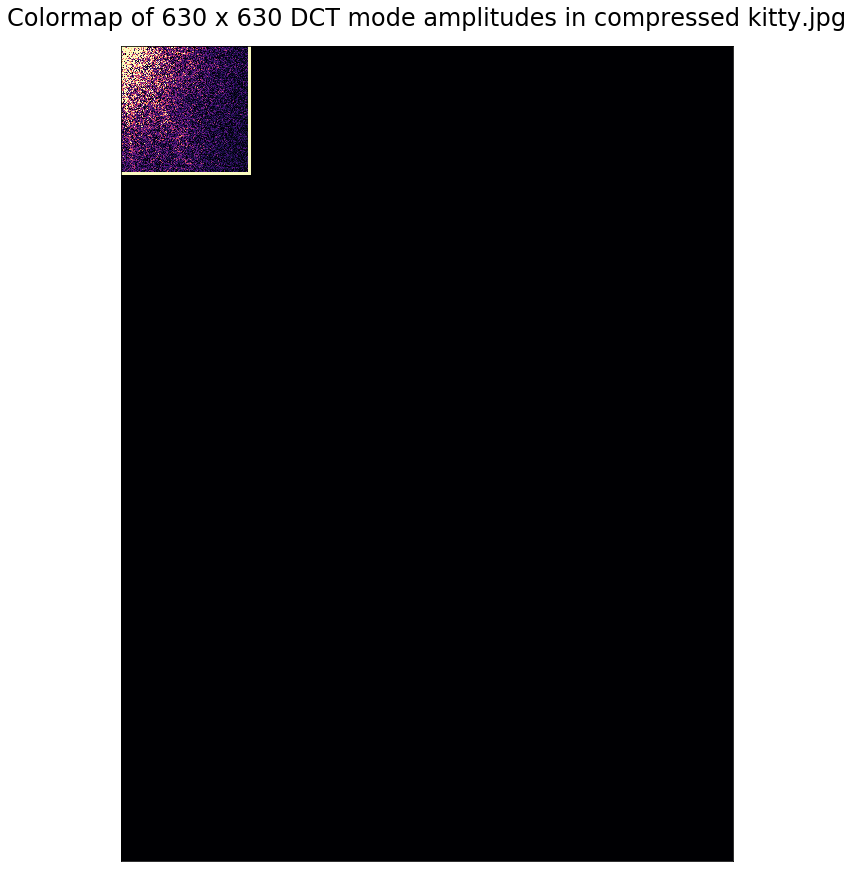

In [99]:
# Plot of frequency intensities

pixels = get_image_from_file(image_filename='kitty.jpg', size=(4032, 3024))
dct_size = pixels.shape[0]
dct = get_2D_dct(pixels)
plt.rcParams['font.size'] = 20
plt.rcParams['axes.titlepad'] = 20

# creating 'mode box' that corresponds to 30x compressed image
lastRowCol = 630

dct_copy = dct.copy()
dct_copy[lastRowCol:,:] = 0
dct_copy[:,lastRowCol:] = 0

dct_copy[0:lastRowCol,lastRowCol:lastRowCol+10] = 255
dct_copy[lastRowCol:lastRowCol+10,0:lastRowCol+10] = 255

dct_copy_norm = abs(dct_copy)/np.amax(abs(dct_copy))

# Reconstructed image of dct coeffs
reconstructed_image = get_reconstructed_image(abs(dct_copy));

plt.figure(figsize=(15,15))
plt.title('Colormap of 630 x 630 DCT mode amplitudes in compressed kitty.jpg')
plt.imshow(reconstructed_image, cmap=plt.cm.magma)
plt.grid(False);
plt.xticks([]);
plt.yticks([]);

Finally, we can visualize some of the modal functions themselves. That'll conclude this example.

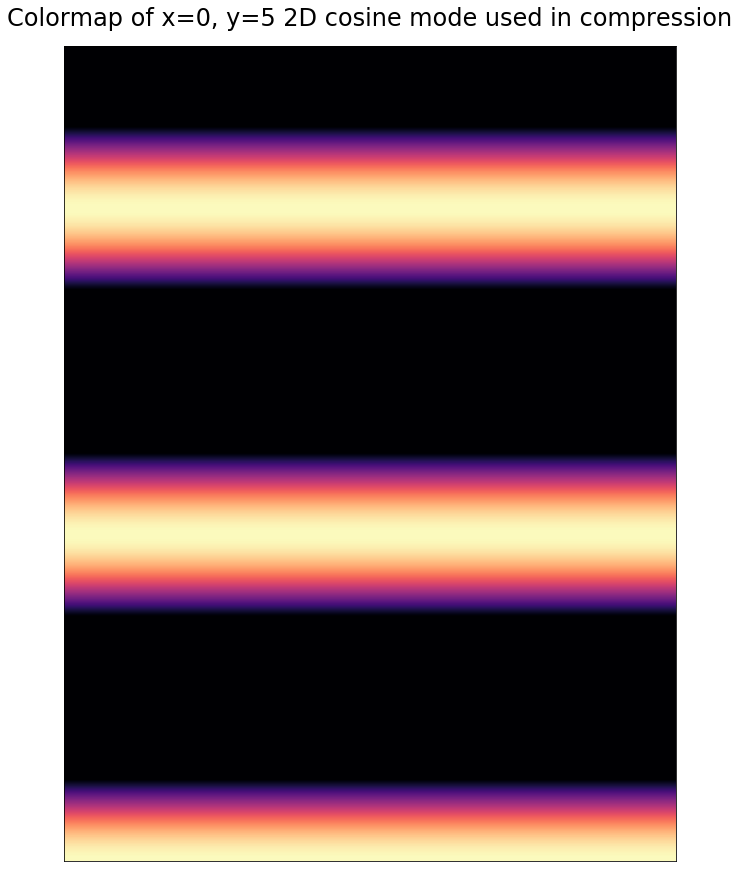

In [143]:
pixels = get_image_from_file(image_filename='kitty.jpg', size=(4032, 3024))
dct_size = pixels.shape[0]
dct = get_2D_dct(pixels)
plt.rcParams['font.size'] = 20
plt.rcParams['axes.titlepad'] = 20

selectModeX = 0
selectModeY = 5

dct_copy = dct.copy()
dct_copy[0:selectModeY,:] = 0
dct_copy[selectModeY+1:,:] = 0
dct_copy[:,0:selectModeX] = 0
dct_copy[:,selectModeX+1:] = 0

# Reconstructed image
r_img = get_2d_idct(dct_copy);
reconstructed_image = get_rescaled_reconstructed_image(r_img);

plt.figure(figsize=(15,15))
plt.imshow(reconstructed_image, cmap=plt.cm.magma)
plt.title('Colormap of x={}, y={} 2D cosine mode used in compression'.format(selectModeX, selectModeY))
plt.grid(False);
plt.xticks([]);
plt.yticks([]);

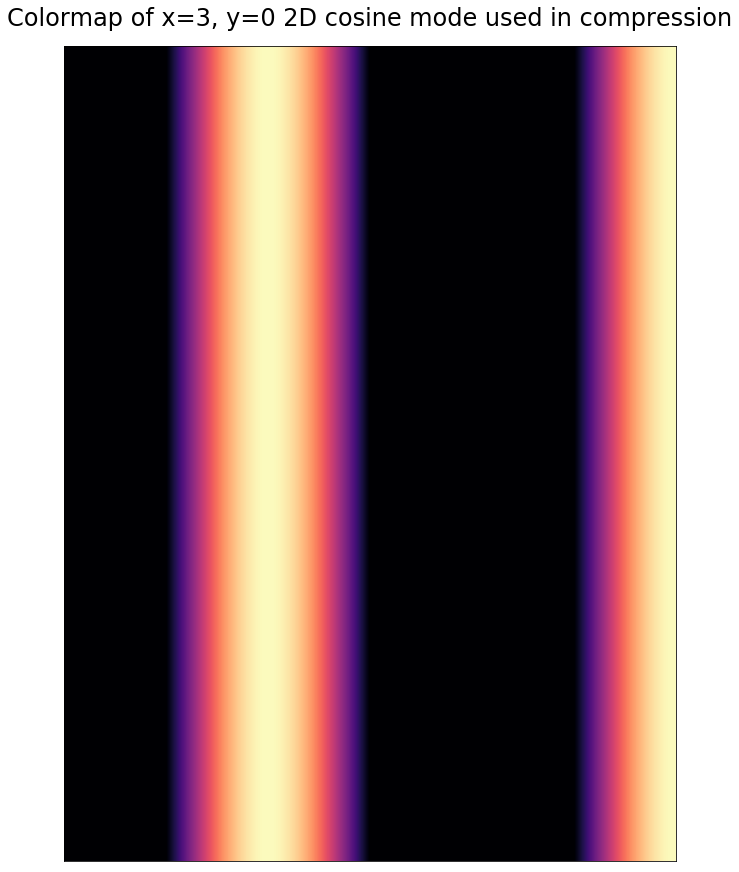

In [144]:
pixels = get_image_from_file(image_filename='kitty.jpg', size=(4032, 3024))
dct_size = pixels.shape[0]
dct = get_2D_dct(pixels)
plt.rcParams['font.size'] = 20
plt.rcParams['axes.titlepad'] = 20

selectModeX = 3
selectModeY = 0

dct_copy = dct.copy()
dct_copy[0:selectModeY,:] = 0
dct_copy[selectModeY+1:,:] = 0
dct_copy[:,0:selectModeX] = 0
dct_copy[:,selectModeX+1:] = 0

# Reconstructed image
r_img = get_2d_idct(dct_copy);
reconstructed_image = get_rescaled_reconstructed_image(r_img);

plt.figure(figsize=(15,15))
plt.imshow(reconstructed_image, cmap=plt.cm.magma)
plt.title('Colormap of x={}, y={} 2D cosine mode used in compression'.format(selectModeX, selectModeY))
plt.grid(False);
plt.xticks([]);
plt.yticks([]);

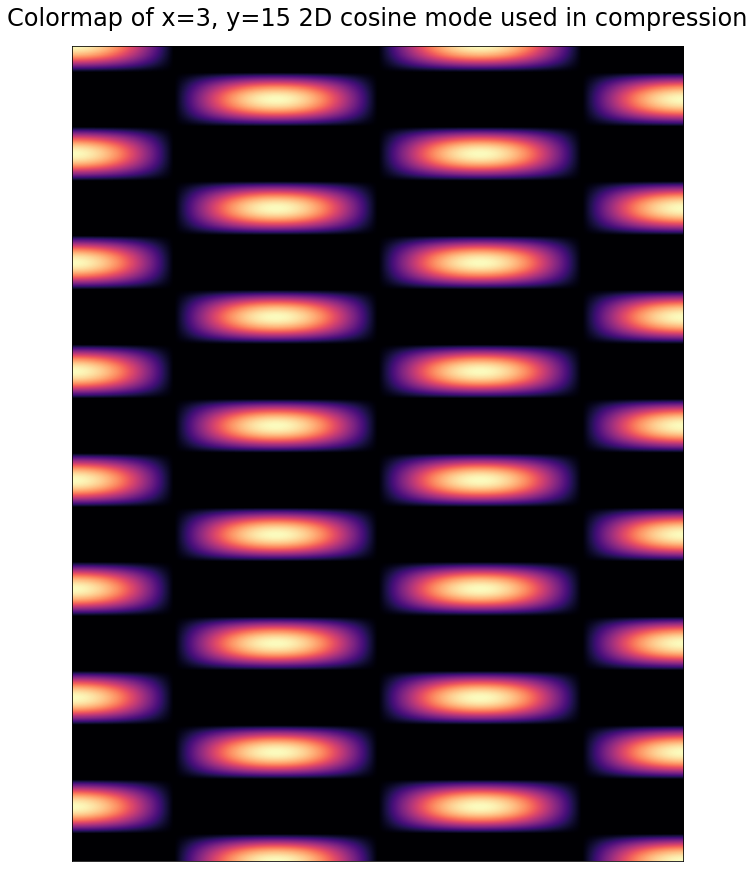

In [142]:
pixels = get_image_from_file(image_filename='kitty.jpg', size=(4032, 3024))
dct_size = pixels.shape[0]
dct = get_2D_dct(pixels)
plt.rcParams['font.size'] = 20
plt.rcParams['axes.titlepad'] = 20

selectModeX = 3
selectModeY = 15

dct_copy = dct.copy()
dct_copy[0:selectModeY,:] = 0
dct_copy[selectModeY+1:,:] = 0
dct_copy[:,0:selectModeX] = 0
dct_copy[:,selectModeX+1:] = 0

# Reconstructed image
r_img = get_2d_idct(dct_copy);
reconstructed_image = get_rescaled_reconstructed_image(r_img);

plt.figure(figsize=(15,15))
plt.imshow(reconstructed_image, cmap=plt.cm.magma)
plt.title('Colormap of x={}, y={} 2D cosine mode used in compression'.format(selectModeX, selectModeY))
plt.grid(False);
plt.xticks([]);
plt.yticks([]);

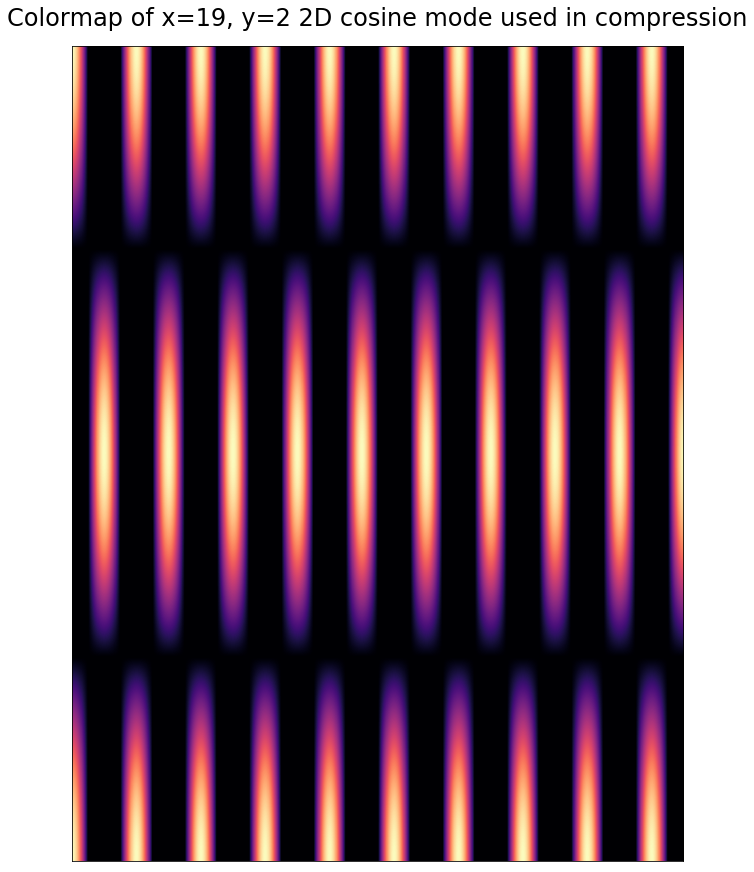

In [145]:
pixels = get_image_from_file(image_filename='kitty.jpg', size=(4032, 3024))
dct_size = pixels.shape[0]
dct = get_2D_dct(pixels)
plt.rcParams['font.size'] = 20
plt.rcParams['axes.titlepad'] = 20

selectModeX = 19
selectModeY = 2

dct_copy = dct.copy()
dct_copy[0:selectModeY,:] = 0
dct_copy[selectModeY+1:,:] = 0
dct_copy[:,0:selectModeX] = 0
dct_copy[:,selectModeX+1:] = 0

# Reconstructed image
r_img = get_2d_idct(dct_copy);
reconstructed_image = get_rescaled_reconstructed_image(r_img);

plt.figure(figsize=(15,15))
plt.imshow(reconstructed_image, cmap=plt.cm.magma)
plt.title('Colormap of x={}, y={} 2D cosine mode used in compression'.format(selectModeX, selectModeY))
plt.grid(False);
plt.xticks([]);
plt.yticks([]);